this file makes sure that my glm r wrapper works as expected.

mostly, I need to check that I can extract intercept and coefficients correctly.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from tang_jcompneuro.glm_r import glmnet_interface as glmnet_interface_r
from tang_jcompneuro.glm_matlab import glmnet_interface as glmnet_interface_matlab, glmnet_lambda_sequence
from tang_jcompneuro.glm import glm_predict as glm_predict_generic
from tang_jcompneuro.glm import check_glm_fit_result

/home/yimengzh_everyday/miniconda2/envs/tf15/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)
/home/yimengzh_everyday/miniconda2/envs/tf15/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: foreach

  warnings.warn(x, RRuntimeWarning)
/home/yimengzh_everyday/miniconda2/envs/tf15/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loaded glmnet 2.0-13


  warnings.warn(x, RRuntimeWarning)


In [3]:
# try toy model.

def prepare_data(family):
    rng_state = np.random.RandomState(seed=0)
    X_train = rng_state.randn(1000,5)
    coef = np.zeros(5)
    coef[[1, 3, 4]] = np.array([.4, .2, .3])
    bias = -1
    y_linear = X_train@coef + bias
    y_linear = y_linear[:,np.newaxis]
    if family == 'gaussian':
        return X_train, y_linear
    elif family == 'poisson':
        return X_train, np.exp(y_linear)
    elif family == 'softplus':
        return X_train, np.log(np.exp(y_linear)+1)
    else:
        raise NotImplementedError

In [4]:
def generate_set_of_params(family):
    return {
        'std': {'alpha': 1.0, 'standardize': True, 'family': family},
        'nostd': {'alpha': 1.0, 'standardize': False, 'family': family}
    }



In [5]:
def check_small_func(x1, x2):
    assert x1.shape == x2.shape
    assert abs(x1-x2).max() <= 1e-4

def compare_two_interface(result_matlab, result_r):
    lam_seq_m, coef_seq_m, bias_seq_m = result_matlab
    lam_seq_r, coef_seq_r, bias_seq_r = result_r
    
    n_lam = min(lam_seq_m.size, lam_seq_r.size)
    print(f'matlab {lam_seq_m.size}, R {lam_seq_r.size}, share {n_lam}')
    
    check_small_func(lam_seq_m[:n_lam],lam_seq_r[:n_lam])
    check_small_func(bias_seq_m[:n_lam],bias_seq_r[:n_lam])
    check_small_func(coef_seq_m[:n_lam],coef_seq_r[:n_lam])

In [6]:
def work_on_one_family(family, call_r=True):
    X, y = prepare_data(family)
    for setup_name, kwargs in generate_set_of_params(family).items():
        interface_return = glmnet_interface_matlab(X, y, **kwargs)
        
        lambda_seq = glmnet_lambda_sequence(X, y, **kwargs)
        # check lambda sequence.
        assert lambda_seq[:interface_return[0].size].shape == interface_return[0].shape
        # because there is * and / of weight inside.
        assert np.allclose(lambda_seq[:interface_return[0].size], interface_return[0])
        # check lambda sequence smaller.
        lambda_seq_2 = glmnet_lambda_sequence(X, y, **kwargs, nlambda=10)
        assert abs(lambda_seq[[0, -1]]-lambda_seq_2[[0,-1]]).max() < 1e-6
        
        check_glm_fit_result(interface_return, X.shape[1])
        if call_r:
            interface_return_r = glmnet_interface_r(X, y, **kwargs)
            check_glm_fit_result(interface_return_r, X.shape[1])
            # then compare.
            compare_two_interface(interface_return, interface_return_r)
        # then plot
        plt.close('all')
        # use smallest lambda.
        y_best = glm_predict_generic(X, interface_return[1][-1],
                                    interface_return[2][-1],family)
        plt.scatter(y.ravel(), y_best)
        plt.plot([y.min(),y.max()],[y.min(),y.max()], linestyle='--')
        plt.axis('equal')
        plt.title('{:.4f}'.format(interface_return[0][-1]))
        plt.show()
        

matlab 41, R 41, share 41


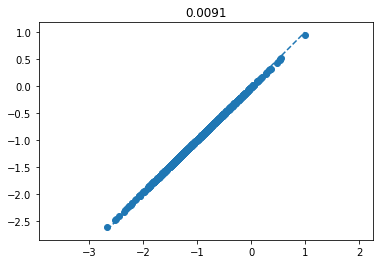

matlab 40, R 40, share 40


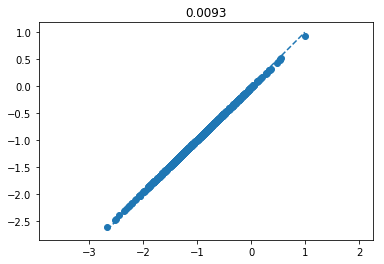

In [7]:
work_on_one_family('gaussian')

matlab 40, R 40, share 40


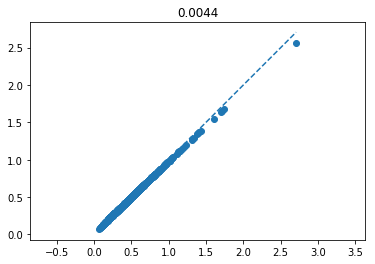

matlab 40, R 40, share 40


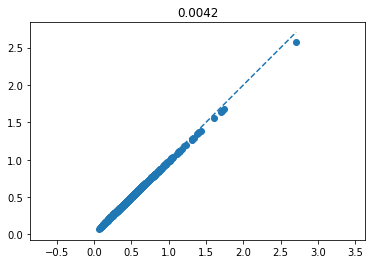

In [8]:
work_on_one_family('poisson')

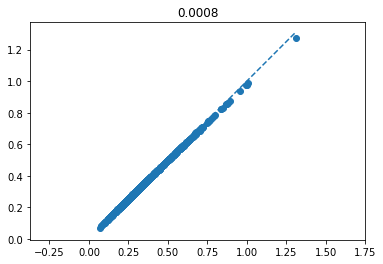

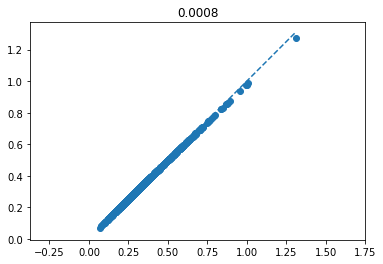

In [9]:
work_on_one_family('softplus', False)